# Flujo óptico

El [flujo óptico](https://en.wikipedia.org/wiki/Optical_flow) es el movimiento aparente de los elementos de una imagen (puntos, bordes, etc.) debido al movimiento del observador o la escena. Informalmente, es un campo vectorial que indica el movimiento de cada "pixel" respecto al fotograma anterior.

En este capítulo estudiaremos un método eficiente de estimación del flujo óptico. Necesitaremos dos conceptos previos: la *correlación* cruzada y la matriz de *covarianza* de un conjunto de vectores.

## Funciones auxiliares

In [1]:
import numpy as np
import cv2   as cv
import matplotlib.pyplot as plt
%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def gray2float(x):
    return x.astype(float) / 255

def readrgb(file):
    return cv.cvtColor( cv.imread("../images/"+file), cv.COLOR_BGR2RGB) 

import glob

def readfiles(path):
    return [readrgb(file) for file in sorted(glob.glob('../images/'+path))]

def resizeS(s,x):
    return cv.resize(x,(0,0), fx = s, fy = s)

def gaussian(s,x):
    return s * cv.GaussianBlur(x,(0,0), s)

def grad(x):
    gx = cv.Sobel(x,-1,1,0)
    gy = cv.Sobel(x,-1,0,1)
    return gx,gy

# para ver imágenes monocromas autoescalando el rango
def imshowg(x):
    plt.imshow(x, 'gray')

# para ver imágenes monocromas de float con rango fijo
def imshowf(x):
    plt.imshow(x, 'gray', vmin = 0, vmax=1)
    
# para ver imágenes con signo
def imshows(x,r=1):
    plt.imshow(x, 'gray', vmin = -r, vmax=r)

Para mostrar el gradiente como un campo de vectores.

In [2]:
def dom(sz, by=1):
    r,c = sz
    x,y = np.meshgrid(range(0,c,by),range(0,r,by))
    return x,y

def showgradient(x):
    gx,gy = grad(x)
    c1,r1 = dom(x.shape)
    r2 = -gy[r1,c1]   # filas = - eje Y
    c2 =  gx[r1,c1]
    plt.quiver(c1, r1, c2, r2, color='green', width=0.002, scale=1, scale_units='xy');

Para dibujar la elipse de incertidumbre.

In [3]:
cir = np.array([ [np.cos(t), np.sin(t)] for t in np.linspace(0,2*np.pi, 40) ])

def rot(a):
    c = np.cos(a)
    s = np.sin(a)
    return np.array([[c,-s],
                     [s, c]])

def ellip(mx,my,s1,s2,a):
    return np.array([mx,my]) + cir @ np.diag([s1,s2]) @ rot(-a)

def uncer_ellipse(x,d=2):
    m = np.mean(x,axis=0)
    c = np.cov(x,rowvar=False)
    l,v = np.linalg.eigh(c)
    sl1 = np.sqrt(l[0])
    sl2 = np.sqrt(l[1])
    v1 = v[:,0]
    v2 = v[:,1]
    e = ellip(m[0],m[1],d*sl2,d*sl1,np.arctan2(v2[1],v2[0]))
    return e

## Localización mediante *cross-correlation*

Un método especialmente simple de detección de objetos consiste comparar directamente los valores de pixel del modelo con los de la imagen en todas las posibles localizaciones (*template matching*). Para añadir una cierta invarianza a brillo y contraste es conveniente utilizar la [correlación](https://en.wikipedia.org/wiki/Cross-correlation) como medida de similitud.

In [4]:
imgs = readfiles('../images/ccorr/scenes/*.png')
mods = readfiles('../images/ccorr/models/*.png')

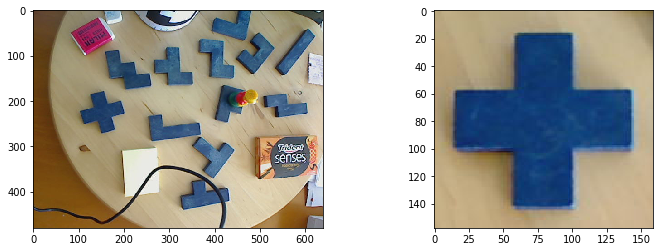

In [5]:
img = imgs[3]
mod = resizeS(1,mods[0])

fig(12,4)
plt.subplot(1,2,1); plt.imshow(img)
plt.subplot(1,2,2); plt.imshow(mod);

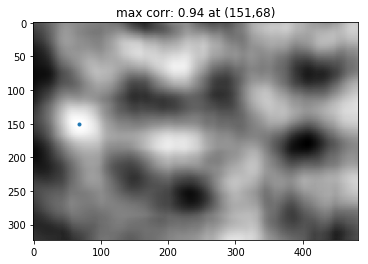

In [6]:
cc = cv.matchTemplate(img,mod,cv.TM_CCORR_NORMED)
mr,mc = divmod(cc.argmax(),cc.shape[1])

plt.title('max corr: {:.02f} at ({},{})'.format(cc.max(),mr,mc))
plt.imshow(cc,'gray');
plt.plot([mc],[mr],'.');

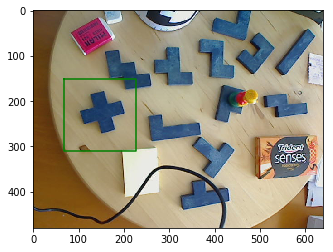

In [7]:
tr,tc = mod.shape[:2]
plt.imshow(img); ax = plt.axis();
plt.plot([mc,mc+tc,mc+tc,mc,mc],[mr,mr,mr+tr,mr+tr,mr],'g'); plt.axis(ax);

La correlación cruzada es una operación muy parecida a la convolución y puede implementarse de forma eficiente en el dominio de la frecuencia.

### Múltiples escalas

La detección multiescala implica repetir el proceso anterior sobre una [pirámide][1] de imágenes reescaladas a tamaños progresivamente menores.

[1]: https://en.wikipedia.org/wiki/Pyramid_(image_processing)

In [8]:
def crosscorr(x,t):
    cc = cv.matchTemplate(x,t,cv.TM_CCORR_NORMED)
    v = cc.max()
    mr,mc = divmod(cc.argmax(),cc.shape[1])
    tr,tc = t.shape[:2]
    roi = ([mc,mc+tc,mc+tc,mc,   mc],
           [mr,mr,   mr+tr,mr+tr,mr])
    return v,roi

In [9]:
def pyr(x):
    return [ resizeS(s,x) for s in [0.8**k for k in range(-3,6)]]

def best(x,t):
    can = [ (crosscorr(sx,t), sx) for sx in pyr(x) if all(np.array(sx.shape) >= np.array(t.shape))]
    return max(can)

0.891532


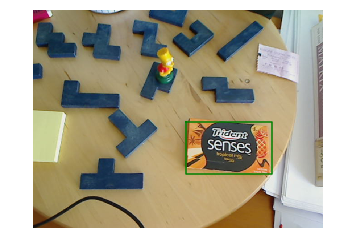

In [10]:
mod = mods[1]
img = imgs[1]

(v, (x,y)), s =  best(img,mod)
print(v)

plt.imshow(s); ax = plt.axis();
plt.plot(x,y,'green')
plt.axis(ax); plt.axis('off');

En realidad la correlación es un método frágil, que solo tiene éxito para detectar objetos rígidos en orientación fija y en escenas controladas.

Sin embargo, proporciona un marco conceptual muy útil para abordar la detección de fragmentos elementales de imagen localizables con precisión cuando la escena sufre pequeños movimientos.

## Detección de esquinas (corners)

Intuitivamente, las zonas de la imagen aproximadamente constantes son similares a sí mismas cuando se desplazan en cualquier dirección. Los bordes más o menos rectos son similares en la dirección perpendicular. Estos dos tipos de zonas son ambiguas para nuestros actuales propósitos y podemos descartarlas. En cambio, las zonas de "esquina" (*[corners](https://en.wikipedia.org/wiki/Corner_detection)*), donde hay bordes con mucha curvatura, sí pueden localizarse con precisión ya que un pequeño desplazamiento en cualquier dirección produce una gran diferencia entre los pixels correspondientes.

La detección de este tipo de zonas con buena localización espacial puede hacerse de forma eficiente mediante el [método de Harris](https://en.wikipedia.org/wiki/Harris_Corner_Detector), basado en la distribución local del gradiente. Puede demostrarse que la localización de un fragmento de imagen por cross-correlation tendrá mayor éxito cuanto mayor sea el "grosor" de su "tensor de estructura". En la práctica buscamos zonas en las que el gradiente tenga al menos dos direcciones destacadas. Esto ocurre cuando su [elipse de incertidumbre](covarianza.ipynb) tiene un eje menor relativamente grande. (Los ejes de la elipse son las [direcciones principales](https://en.wikipedia.org/wiki/Principal_component_analysis) de la distribución y, matemáticamente corresponden a los [autovalores](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) de la matriz de covarianza.)

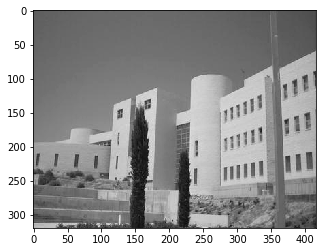

In [11]:
img = readrgb('pano/pano001.jpg')
x = gray2float(rgb2gray(img))

plt.imshow(x,'gray');

Veamos el gradiente ampliando una zona y consideremos los puntos A,B y C.

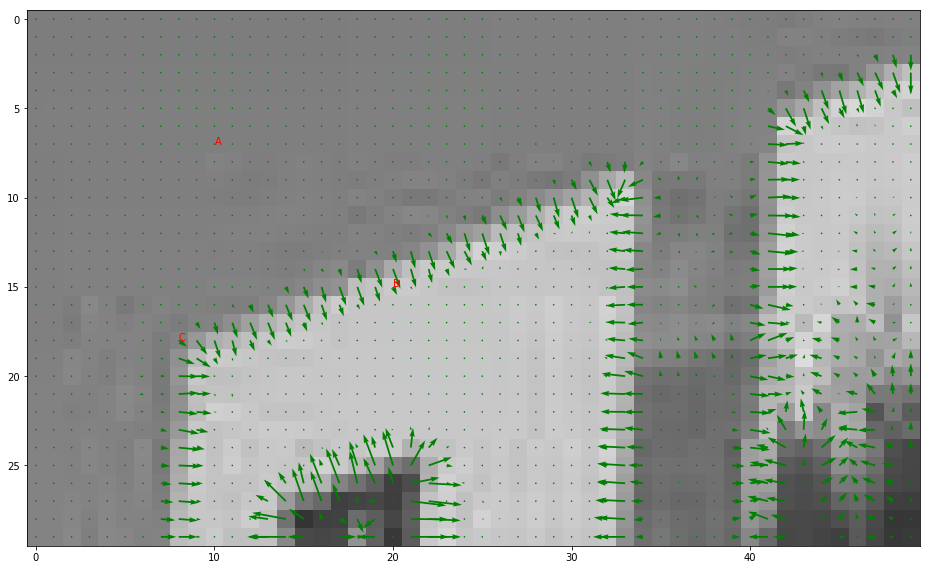

In [12]:
trozo = x[120:150,110:160]
    
fig(16,14)
plt.imshow(trozo,'gray',vmin=0,vmax=1)
showgradient(trozo)
#plt.imshow(gx,'coolwarm',vmin=-128,vmax=128)

plt.text(10,7,'A',color='red'); plt.text(20,15,'B',color='red'); plt.text(8,18,'C',color='red');

Vamos a dibujar las "puntas de flecha" de los gradientes en un entorno de cada punto (con la base en ese punto). Es una forma de mostrar la distribución local del gradiente.

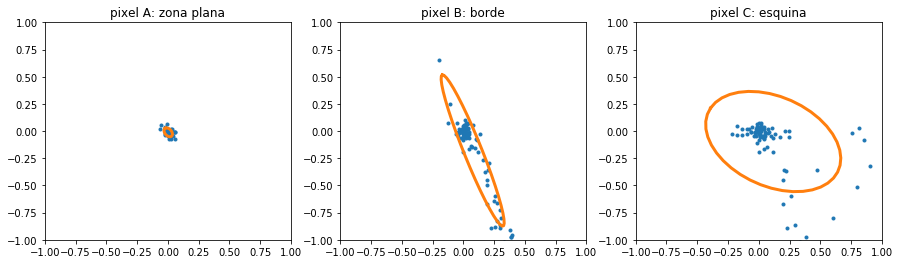

In [13]:
gx,gy = grad(trozo)

def estructura(i,j,n):
    dx = gx[i-n:i+n,j-n:j+n].flatten()
    dy = -gy[i-n:i+n,j-n:j+n].flatten()
    plt.plot(dx,dy,'.')
    plt.plot(*uncer_ellipse(np.array([dx,dy]).T).T,lw=3)

fig(5*3,4);

plt.subplot(1,3,1);
estructura(7,10,5); plt.axis([-1,1,-1,1]);
plt.title('pixel A: zona plana')

plt.subplot(1,3,2);
estructura(20,15,5); plt.axis([-1,1,-1,1]);
plt.title('pixel B: borde')

plt.subplot(1,3,3);
estructura(18,8,5); plt.axis([-1,1,-1,1]);
plt.title('pixel C: esquina');

Cada tipo de punto (zonas planas, bordes, esquinas) tiene una distribución de gradiente muy distinta, que podemos caracterizar por el tamaño de los ejes de la elipse de incertidumbre.

Volvemos a la imagen completa. Vamos a calcular el eje menor de la elipse de incertidumbre en cada punto. Para ello necesitamos la matriz de covarianza. Por sencillez consideramos la distribución centrada en el origen.

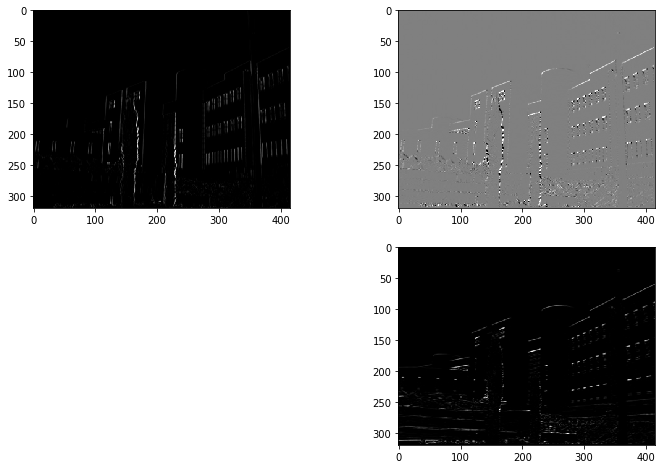

In [14]:
gx,gy = grad(x)

# estos son los elementos cuya media en un entorno forman la matriz de covarianza
# que describe el elipsoide de incerticumbre
gx2 = gx * gx
gy2 = gy * gy
xyg = gx * gy

fig(12,8); 
plt.subplot(2,2,1); imshowg(gx2); 
plt.subplot(2,2,2); imshows(xyg); 
plt.subplot(2,2,4); imshowg(gy2);

La media de esos valores en un entorno se puede obtener con un filtro de promediado.

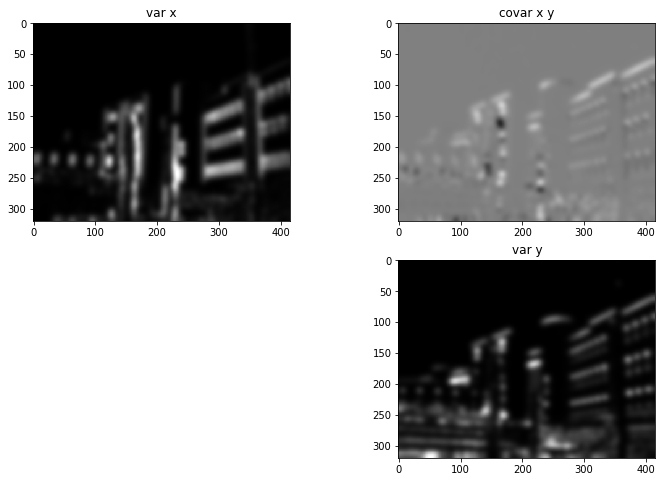

In [15]:
sx2 = gaussian(5,gx2)
sy2 = gaussian(5,gy2)
sxy = gaussian(5,xyg)

fig(12,8)
plt.subplot(2,2,1); imshowg(sx2); plt.title('var x')
plt.subplot(2,2,2); imshows(sxy); plt.title('covar x y')
plt.subplot(2,2,4); imshowg(sy2); plt.title('var y');

Las imagenes anteriores contienen, en los pixels correspondientes, los 3 elementos distintos de la matriz de covarianza que describe el elipsoide de incertidumbre de los gradientes alrededor de cada pixel. Para detectar "corners" necesitamos el menor autovalor. Lo calculamos con la fórmula explícita obtenida mediante cualquier herramienta de cálculo simbólico.

La expresión anterior de $\lambda _ {min} $ se puede obtener fácilmente mediante `sympy`:

In [16]:
import sympy as sym

a,b,c = sym.symbols('a b c')

m = sym.Matrix( [[a,b]
                ,[b,c]] )

m

Matrix([
[a, b],
[b, c]])

In [17]:
m.eigenvals()

{a/2 + c/2 + sqrt(a**2 - 2*a*c + 4*b**2 + c**2)/2: 1,
 a/2 + c/2 - sqrt(a**2 - 2*a*c + 4*b**2 + c**2)/2: 1}

In [18]:
sym.init_printing()

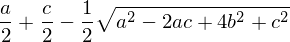

In [19]:
list(m.eigenvals().keys())[0]

In [20]:
sym.init_printing(pretty_print=False)

La calculamos en toda la imagen:

In [21]:
lmin = sx2 + sy2 - np.sqrt(sx2**2 + sy2**2 + 4*sxy**2 - 2*sx2*sy2)

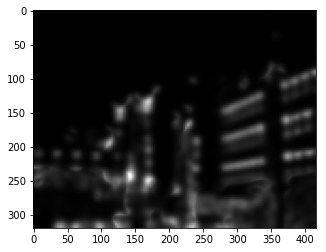

In [22]:
imshowg(lmin)

Finalmente buscamos los máximos locales del detector y extraemos las coordenadas de cada punto:

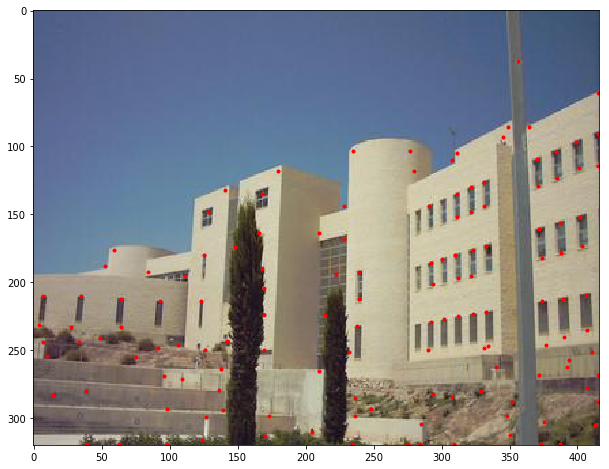

In [23]:
# FIXME

# puntos iguales que el máximo local
def nms(x, t = 0.1):
    m = cv.dilate(x, np.ones((5,5),np.uint8))  # filtro de máximo
    h = np.max(m)
    return (x == m) & (x > t*h)

k = nms(lmin,0.01)

py,px = np.where(k)

fig(12,8)
plt.imshow(img); ax = plt.axis();
plt.plot(px,py,'.r'); plt.axis(ax);

Este detector está disponible directamente en OpenCV (`goodFeaturesToTrack`). Suele utilizarse para determinar el desplazamiento entre imágenes sucesivas para aplicaciones de *tracking*. El criterio utilizado (que tenga bordes en diferentes direcciones) hace que el punto se pueda localizar con mucha precisión en diferentes imágenes.

(100, 1, 2)


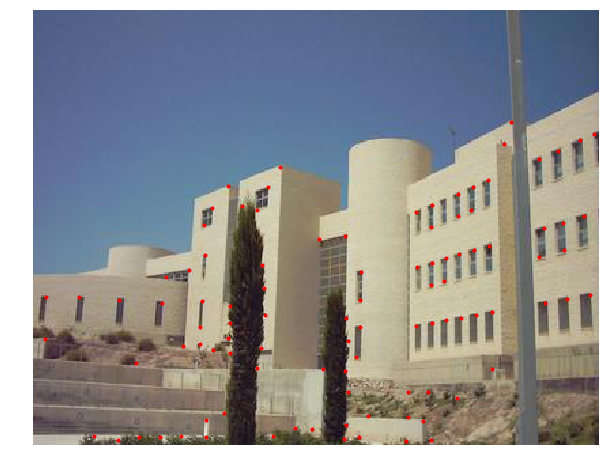

In [24]:
g = rgb2gray(img)

corners = cv.goodFeaturesToTrack(g, maxCorners=100, qualityLevel=0.01, minDistance=10)

print(corners.shape)

corners = corners.reshape(corners.shape[0],2)

fig(12,8)
plt.imshow(img); ax = plt.axis('off');
plt.plot(corners[:,0],corners[:,1],'.r'); plt.axis(ax);

## *Point tracking*

El ejemplo de código [`lk_track.py`](../code/lk_track.py) muestra la detección y seguimiento de puntos destacados para estimar el [flujo óptico](https://en.wikipedia.org/wiki/Optical_flow). En este caso es un flujo *sparse*, disponible solo en los puntos detectados. (La obtención de flujo denso requiere mucho mayor esfuerzo computacional.)

A continuación se muestra una prueba de concepto del método de seguimiento de [Lucas-Kanade](https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method).

Para ello usaremos como ejemplo un "punto difuso" que se desplaza a una velocidad que suponemos desconocida:

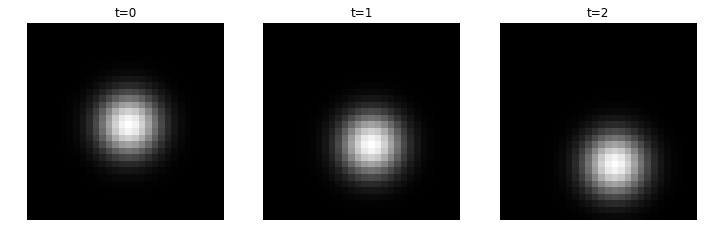

In [25]:
r = np.arange(30)
x,y = np.meshgrid(r,r)

vx,vy = 1,3

def f(x,y,t):
    return np.exp(-0.5*((x-15-vx*t)**2+(y-15-vy*t)**2)/10)

fig(12,4)
plt.subplot(1,3,1); plt.imshow(f(x,y,0),'gray'); plt.axis('off'); plt.title('t=0')
plt.subplot(1,3,2); plt.imshow(f(x,y,1),'gray'); plt.axis('off'); plt.title('t=1');
plt.subplot(1,3,3); plt.imshow(f(x,y,2),'gray'); plt.axis('off'); plt.title('t=2');

Nuestro objetivo es deducir "directamente" la velocidad de esta mancha, sin explorar todas las posibles localizaciones en el frame siguiente.

En el caso unidimensional la secuencia de imágenes puede modelarse localmente como una forma constante $g$ que se desplaza:

$$f(x,t) = g(x-vt)$$

Una forma de "despejar" la velocidad es tomar derivadas parciales:

$$f_x \equiv \frac{\partial f(x,t)} {\partial x} = g'(x-vt) \hspace{4em}
f_t \equiv \frac{\partial f(x,t)} {\partial t} = g'(x-vt) \;(-v)$$

Por tanto:

$$v = \frac{-f_t }{f_x}$$


El caso bidimensional es más interesante:

$$f(x,y,t) = g(x-v_x t\,,\, y-v_y t)$$

$$\frac{\partial f(x,y,t)} {\partial x} = \frac{\partial g(x-v_x t \,,\, y-v_y t)}{\partial x}$$

$$\frac{\partial f(x,y,t)} {\partial y} = \frac{\partial g(x-v_x t\,,\, y-v_y t)}{\partial y}$$

$$\frac{\partial f(x,y,t)} {\partial t} = -v_x \frac{\partial g(x-v_x t \,,\, y-v_y t)}{\partial x} -v_y \frac{\partial g(x-v_x t\,,\, y-v_y t)}{\partial y} = - v \cdot \nabla f(x,y,t) $$

Ahora las derivadas en cada punto no determinan unívocamente la velocidad $v = (v_x,v_y)$, sino que imponen una restricción a sus componentes. Es necesario resolver un sistema agrupando las ecuaciones correspondientes a un pequeño entorno de cada punto. (Bastarían dos, pero se usan más para ganar robustez.) El sistema tendrá solución única en las zonas con varias direcciones de gradiente.

En la práctica, las derivadas parciales se aproximan mediante diferencias finitas (o convolución con máscaras de Sobel) y diferencias entre frames consecutivos. Por tanto, la precisión será mayor cuanto menor sea la velocidad en pixels/frame. De ahí la necesidad de crear una pirámide de escalas.

Calculamos una aproximación a las derivadas parciales:

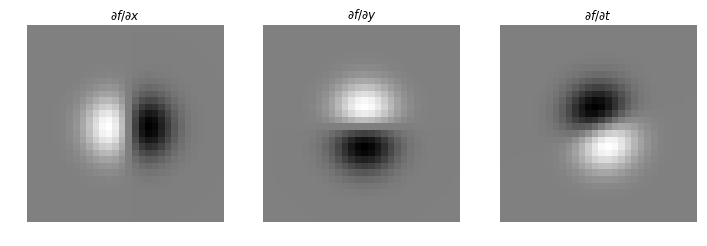

In [26]:
if True:
    vx,vy = 1,3
    ht = h = 0.001
else:
    vx, vy = 0.2,0.7
    h = 1; ht = 1

dx = (f(x+h,y,0) - f(x,y,0))/h
dy = (f(x,y+h,0) - f(x,y,0))/h
dt = (f(x,y,0+ht) - f(x,y,0))/ht

fig(12,4)
plt.subplot(1,3,1); plt.imshow(dx,'gray'); plt.axis('off'); plt.title('$\partial f / \partial x$')
plt.subplot(1,3,2); plt.imshow(dy,'gray'); plt.axis('off'); plt.title('$\partial f / \partial y$');
plt.subplot(1,3,3); plt.imshow(dt,'gray'); plt.axis('off'); plt.title('$\partial f / \partial t$');

Partimos las derivadas en trozos 3x3 en los que resolveremos el [sistema sobredeterminado](sistecs.ipynb) (9 ecuaciones y 2 incógnitas) por mínimos cuadrados.

In [27]:
def split(img,sz):
    r,c = img.shape
    return np.array([np.split(x, c//sz, axis=1) for x in np.split(img,r//sz)])

In [28]:
tx  = split(x,3)
ty  = split(y,3)
tdx = split(dx,3)
tdy = split(dy,3)
tdt = split(dt,3)

r = []
for i in range(len(tx)):
    for j in range(len(tx[0])):
        ddx = tdx[i,j].reshape(-1,1)
        ddy = tdy[i,j].reshape(-1,1)
        ddt = tdt[i,j].reshape(-1)
        A = np.hstack([-ddx,-ddy])
        B = ddt
        (vx,vy), _, _,sv = np.linalg.lstsq(A,B)
        r.append((tx[i,j,1,1],ty[i,j,1,1], vx, vy, sv.min()))

Pero solo representamos la solución en las posiciones donde el sistema está bien condicionado (el menor valor singular debe ser suficientemente grande). Esto ocurre cuando hay un gradiente apreciable en dos direcciones.

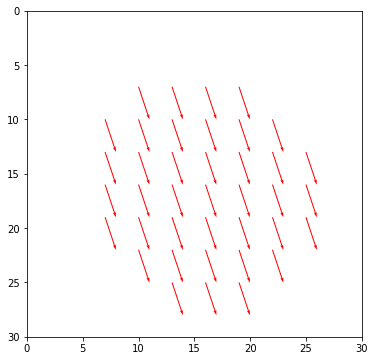

In [29]:
cx,cy,qx,qy,s = np.array(r).T
ok = s > 1e-3
fig(6,6)
plt.quiver(cx[ok], cy[ok], qx[ok], -qy[ok], color='Red',
           width=0.003, scale=1, scale_units='xy');
plt.axis([0,30,30,0]);

La estimación de la velocidad es bastante precisa cuando la velocidad es inferior a 1 pixel/frame:

In [30]:
qx[ok].mean(), qy[ok].mean()

(1.00010329113, 3.00047597104)

Cambiando los valores de vx, vy, h, y ht más arriba se puede estudiar el punto de ruptura.

El método de Lucas-Kanade admite transformaciones de dominio más generales que pueden incluir escalados, rotaciones, e incluso deformaciones de perspectiva. Su variante [composicional inversa](https://www.ri.cmu.edu/pub_files/pub4/baker_simon_2004_2/baker_simon_2004_2.pdf) es particularlmente eficiente.